# Part 3 - the Fashion-MNIST dataset

In Part 2 we successfully applied a 3-layer perceptron (with 400, 150 hidden units) to the MNIST dataset. Without using any data augmentation techniques, the trained model fairly quickly achieved 97.9% accuracy without a whole lot of hyperparameter tuning. While that's some way off the [state of the art](http://yann.lecun.com/exdb/mnist/) I think it's pretty good for a very small model (by modern standards) with a not particularly sophisticated architecture, that can be trained in about a minute on a mid-spec laptop.

Rather than continuing to thrash the model on the MNIST, let's move on to a [more challenging](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/#) dataset: The [Fashion MNIST](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/), developed and [generously made publicly available](https://github.com/zalandoresearch/fashion-mnist) by Zalando. It also functions as a drop-in replacement for MNIST, consisting of 28x28 greyscale images and 10 possible classes.

Let's see how far we get just running the previous model on the Fashion MNIST dataset.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math
import time
from tensorflow.python.framework import ops

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

fashion_mnist = tf.keras.datasets.fashion_mnist


/home/nickdbn/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Conveniently, the train & test sets have the same number of training/text examples to the original MNIST.

In [2]:
(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0 # normalise

# reshape y to arrays of shape (m,1)
y_train, y_test = y_train.reshape(y_train.shape[0], 1), y_test.reshape(y_test.shape[0], 1)

print ("x_train shape:", x_train.shape)
print ("y_train shape:", y_test.shape)
print ("x_test shape:", x_train.shape)
print ("y_test shape:", y_test.shape)

x_train shape: (60000, 28, 28)
y_train shape: (10000, 1)
x_test shape: (60000, 28, 28)
y_test shape: (10000, 1)


Once again, let's visualise some examples of the training set with their labels

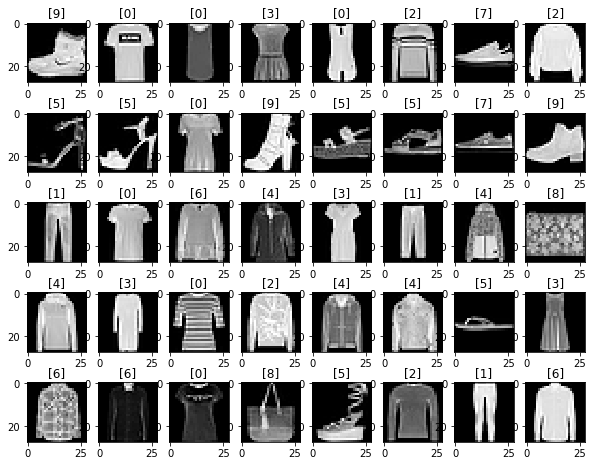

In [3]:
display_examples_n = 40
rows = 5
cols = 8
fig, axarr = plt.subplots(rows, cols)

for r in range (0, rows):
    for c in range (0, cols):
        # axarr[r][c].title.set_text('x_train[' + str((r*cols)+c) +']: ' + str(y_train[(r*cols)+c]))
        axarr[r][c].title.set_text(str(y_train[(r*cols)+c]))
        axarr[r][c].imshow(x_train[(r*cols)+c])

This time, the number of items in each class is conveniently uniform:

In [4]:
np.unique (y_train, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [5]:
np.unique (y_test, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

As the number of items in each class is the same, a chunk of the code below is redundant but it'll work fine on this dataset anyway.

In [6]:
def get_train_dev_sets (X, Y, train_set_proportion = 0.9):
    """
    Takes set of features (X) as (n,m) matrix and labels (Y) as (1,m) matrix and splits them 
    into train and dev sets only, of specified proportions. It's assumed that a test set 
    isn't needed.
    Train set will have same number of examples of each class
    
    returns: train_set_X, train_set_Y, dev_set_X, dev_set_Y
    """
    
    size_classes = np.unique(Y, return_counts = True)[1] # get an array of all class sizes

    # our training set contains train_set_proportion * smallest class size of each class
    size_smallest_class = min (np.unique (Y, return_counts = True)[1]) 
    size_train_set_class = int (train_set_proportion * size_smallest_class)
    print ("size_train_set_class:", size_train_set_class)
    
    
    num_classes = np.shape(np.unique(Y))[0]

    size_classes_cum = np.empty ((0))
    
    # get an array of cumulative indices, starting with 0, for where each class starts
    for i in range (0, num_classes): 
        size_classes_cum = np.append (size_classes_cum, int (sum(size_classes[0:i])))
    # add on final size of the data set +1 so we can iterate i+1 over num_classes to get end indices
    size_classes_cum = np.append (size_classes_cum, int(Y.shape[1]))
    
    sorted_indices = np.argsort (Y[0,:]) # get the list of indices that will sort Y by class
    X_sorted = X[:, sorted_indices]
    Y_sorted = Y[:, sorted_indices] 
       
    # initialise sets
    train_set_X = np.empty ((X.shape[0], 0))
    train_set_Y = np.empty ((1, 0))
    dev_set_X = np.empty ((X.shape[0], 0))
    dev_set_Y = np.empty ((1, 0))
    
    
    for i in range (0, num_classes):
        X_this_class = X_sorted[:, int (size_classes_cum[i]):int (size_classes_cum[i]+size_train_set_class)]
        train_set_X = np.append (train_set_X, 
            X_sorted[:, int (size_classes_cum[i]):int (size_classes_cum[i]+size_train_set_class)], 
                                 axis=1)
        train_set_Y = np.append (train_set_Y, 
            Y_sorted[:, int (size_classes_cum[i]):int (size_classes_cum[i]+size_train_set_class)], 
                                 axis=1)
        dev_set_X = np.append (dev_set_X, 
            X_sorted[:, int (size_classes_cum[i]+size_train_set_class):int(size_classes_cum[i+1])], 
                               axis=1)
        dev_set_Y = np.append (dev_set_Y, 
            Y_sorted[:, int (size_classes_cum[i]+size_train_set_class):int(size_classes_cum[i+1])], 
                               axis=1)

       
    # Finally, apply the same shuffle to X and Y sets
    train_shuffled_indices = np.arange (train_set_X.shape[1])
    dev_shuffled_indices = np.arange (dev_set_X.shape[1])

    np.random.shuffle (train_shuffled_indices)
    np.random.shuffle (dev_shuffled_indices)

    train_set_X = train_set_X[:,train_shuffled_indices]
    train_set_Y = train_set_Y[:,train_shuffled_indices].astype (np.int16)    
    dev_set_X = dev_set_X[:,dev_shuffled_indices]
    dev_set_Y = dev_set_Y[:,dev_shuffled_indices].astype (np.int16)    
    
    return train_set_X, train_set_Y, dev_set_X, dev_set_Y

In [7]:
print ("x_train shape:", x_train.shape)
print ("y_train shape:", y_train.shape)
print ("x_test shape:", x_test.shape)
print ("y_test shape:", y_test.shape)


x_train_unrow = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test_unrow = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

print ("x_train_unrow shape:", x_train_unrow.shape)
print ("x_test_unrow shape:", x_test_unrow.shape)

x_train_trans = x_train_unrow.T
x_test_trans = x_test_unrow.T
y_train_trans = y_train.T
y_test_trans = y_test.T
print ("x_train_trans shape:", x_train_trans.shape)
print ("y_train_trans shape:", y_train_trans.shape)
print ("x_test_trans shape:", x_test_trans.shape)
print ("y_test_trans shape:", y_test_trans.shape)

x_train shape: (60000, 28, 28)
y_train shape: (60000, 1)
x_test shape: (10000, 28, 28)
y_test shape: (10000, 1)
x_train_unrow shape: (60000, 784)
x_test_unrow shape: (10000, 784)
x_train_trans shape: (784, 60000)
y_train_trans shape: (1, 60000)
x_test_trans shape: (784, 10000)
y_test_trans shape: (1, 10000)


Now lets carve up the training and and dev sets. With 60,000 examples, we probably don't need to devote 10% of this to a dev set, so let's set the dev set at just 5% of the training set so that we have a bit more training data.

In [8]:
tic=time.time()
train_set_X, train_set_Y, dev_set_X, dev_set_Y = get_train_dev_sets (x_train_trans, 
                                                                     y_train_trans, 
                                                                     train_set_proportion = 0.95)

#train_set_X = train_set_X.T
#train_set_Y = train_set_Y.T
#dev_set_X = dev_set_X.T
#dev_set_Y = dev_set_Y.T

print ("train_set_X.shape: ", train_set_X.shape)
print ("train_set_Y.shape: ", train_set_Y.shape)
print ("dev_set_X.shape:", dev_set_X.shape)
print ("dev_set_Y.shape:", dev_set_Y.shape)
timer = time.time() - tic
print ("execution time: %f s" % timer)

size_train_set_class: 5700
train_set_X.shape:  (784, 57000)
train_set_Y.shape:  (1, 57000)
dev_set_X.shape: (784, 3000)
dev_set_Y.shape: (1, 3000)
execution time: 2.596117 s


And let's just check perform a sanity check on the re-rowed dev set

dev set X shape:  (3000, 28, 28)


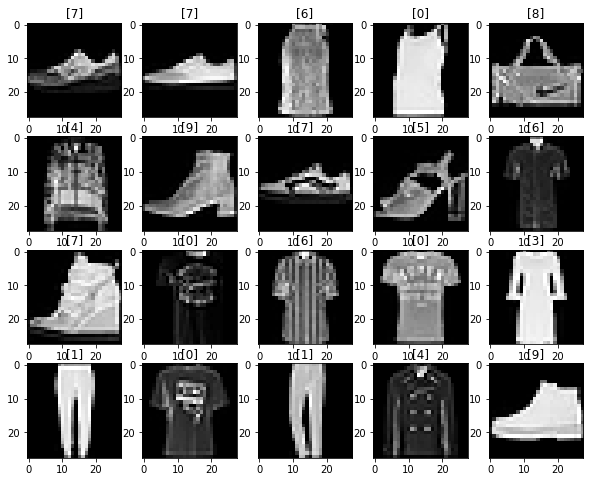

In [9]:
dev_set_X_2d = dev_set_X.T.reshape(dev_set_X.shape[1], 28, 28)
print ("dev set X shape: ", dev_set_X_2d.shape)

display_examples_n = 20
rows = 4
cols = 5
fig, axarr = plt.subplots(rows, cols)

for r in range (0, rows):
    for c in range (0, cols):
        axarr[r][c].title.set_text(str(dev_set_Y.T[(r*cols)+c]))
        axarr[r][c].imshow(dev_set_X_2d[(r*cols)+c])

In [10]:
# Check the size of each class in the training set, should be equal numbers
np.unique (train_set_Y, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int16),
 array([5700, 5700, 5700, 5700, 5700, 5700, 5700, 5700, 5700, 5700]))

In [11]:
def convert_to_one_hot(Y, C): 
    """
    Converts a vector Y of multiclass-responses coded as integer values (0, 1, 2, etc.... C-1) 
    to a (C,m) dimensional matrix where each row represents a response, and values are either 0 or 1
    """
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [12]:
print (train_set_Y[:,0:10])

train_set_Y_one_hot = convert_to_one_hot (train_set_Y,  10)
dev_set_Y_one_hot = convert_to_one_hot (dev_set_Y,  10)
print ("...converts to:")
print (train_set_Y_one_hot[:, 0:10])

[[0 3 5 9 7 1 5 1 1 9]]
...converts to:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]]


In [13]:
def random_mini_batches(X, Y, mini_batch_size = 64):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []

    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) 
                            # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

# The Model

In [14]:
def create_placeholders(n_x, n_y):
    """
    Creates placeholders for input feature vector (X) and labels vector (Y) 
    
    Arguments:
    n_x -- scalar, size of the input feature vector 
    n_y -- scalar, number of classes 
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"

    """

    X = tf.placeholder(dtype="float", shape=(n_x, None), name="X")
    Y = tf.placeholder(dtype="float", shape=(n_y, None), name="Y")
    
    return X, Y

In [15]:
X, Y = create_placeholders(784, 10)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X:0", shape=(784, ?), dtype=float32)
Y = Tensor("Y:0", shape=(10, ?), dtype=float32)


In [16]:
def initialize_parameters_3layers(size_input, size_l1, size_l2, size_l3):
    """
    Initializes parameters for a 3 layer tensorflow neural network, where l1 is the 
    first hidden layer and l3 is the output layer. Uses Xavier initialization.
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)  
    
    W1 = tf.get_variable ("W1", [size_l1,size_input], 
                          initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable ("b1", [size_l1,1], 
                          initializer = tf.zeros_initializer())
    W2 = tf.get_variable ("W2", [size_l2,size_l1], 
                          initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable ("b2", [size_l2,1], 
                          initializer = tf.zeros_initializer())
    W3 = tf.get_variable ("W3", [size_l3,size_l2], 
                          initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable ("b3", [size_l3,1], 
                          initializer = tf.zeros_initializer())


    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [17]:
def forward_propagation_3layers(X, Y, parameters, beta = 0.01):
    """
    Implements the forward propagation for 4 layer network
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing parameters "W1", "b1", "W2", "b2", ... "W5", "b5"
                  the shapes are given in initialize_parameters

    Returns:
    cost -- softmax cross entropy loss
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
                                                      
    Z1 = tf.add(tf.matmul(W1, X), b1)                      
    A1 = tf.nn.relu(Z1)                                    
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     
    A2 = tf.nn.relu(Z2)                                    
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     

    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)    
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    regularizers = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3) 
    cost = tf.reduce_mean(cost + beta * regularizers)
        
    return Z3, cost

# Running the model
Once again, we're using a three-layer model (i.e. a multi-layer perceptron), with layers l1 = 400, l2 = 150, l3 = 10, with l1 through l3 using relu units, and l4 a softmax layer. The parameters are trained via backprop optimising to softmax cross-entropy loss. 

L2 regularization didn't seem to help much on the digits dataset but who knows, let's leave it in here. The default setting of beta is zero.

In [18]:
def plot_training_by_epoch (costs, train_accuracy, test_accuracy, learning_rate):
    
    fig, ax1 = plt.subplots() 
    
    # plot cost on primary y axis 
    cost = ax1.plot(np.squeeze(costs), label="cost", color='b')
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('cost', color='b')
    ax1.tick_params('y', colors='b')
    
    # plot accuracy on secondary y axis
    ax2 = ax1.twinx()
    train_accuracy = ax2.plot(np.squeeze(train_accuracy), 
                              label="train accuracy", color='r', linestyle='-.')
    test_accuracy = ax2.plot(np.squeeze(test_accuracy), 
                             label="test accuracy", color='r', linestyle=':')
    ax2.set_ylabel('accuracy', color='r')
    ax2.tick_params('y', colors='r')
    
    plt.legend(bbox_to_anchor=(1, 1))
    
    plt.title("Learning rate =" + str(learning_rate))
    fig.tight_layout()
    plt.show()

In [28]:
def model(X_train, Y_train, X_test, Y_test, 
          layer_sizes = [784, 400, 150, 10], 
          learning_rate = 0.01, # for Adagrad - with AdamOptimizer, WAS: learning_rate = 0.0001, 
          beta = 0.0,
          num_epochs = 50, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    for m, n-dimensional training examples, with c output classes 
    X_train -- training set, of shape (input size = n, number of training examples = m)
    Y_train -- test set, of shape (output size = c, number of training examples = m)
    X_test -- training set, of shape (input size = n, number of training examples = m)
    Y_test -- test set, of shape (output size = c, number of test examples = m)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()           # to be able to rerun the model without 
                                        # overwriting tf variables
#    tf.set_random_seed(1)               # to keep consistent results
    (n_x, m) = X_train.shape            # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]              # n_y : output size
    costs = []                          # To keep track of the cost (plotting per epoch)
    train_accuracy = []                 # for plotting per epoch
    test_accuracy = []                  # for plotting per epoch
    
    X, Y = create_placeholders (n_x, n_y)
    parameters = initialize_parameters_3layers(size_input = layer_sizes[0], 
                                               size_l1 = layer_sizes[1], 
                                               size_l2 = layer_sizes[2], 
                                               size_l3 = layer_sizes[3])
    Z3, cost = forward_propagation_3layers (X, Y, parameters, beta = beta)
    #optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    optimizer = tf.train.AdagradOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Calculate the correct predictions and accuracy on the test set
    correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    init = tf.global_variables_initializer()

    tic = time.time()
    
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                           # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size 
                                                      # minibatch_size in the train set
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                # the line that runs the optimizer
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, 
                                                                            Y:minibatch_Y})                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                timer = time.time() - tic
                print ("Cost after epoch %i: %f, running for %f seconds" % (epoch, 
                                                                            epoch_cost, timer))
            if print_cost == True and epoch % 1 == 0:
                costs.append(epoch_cost)
                # evaluate accuracy
                train_accuracy.append (accuracy.eval({X: X_train, Y: Y_train}))
                test_accuracy.append (accuracy.eval({X: X_test, Y: Y_test}))
                
        # plot the cost
        plot_training_by_epoch (costs, train_accuracy, test_accuracy, learning_rate)

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        timer = time.time() - tic
        print ("Execution time %f" % timer)

        print ("Final Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Final Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters, costs, train_accuracy, test_accuracy

## Default model run

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 0.575698, running for 15.684340 seconds
Cost after epoch 5: 0.300849, running for 101.950621 seconds
Cost after epoch 10: 0.246114, running for 185.185892 seconds
Cost after epoch 15: 0.209654, running for 269.055214 seconds
Cost after epoch 20: 0.176404, running for 351.324359 seconds
Cost after epoch 25: 0.151167, running for 418.016688 seconds
Cost after epoch 30: 0.128141, running for 481.698035 seconds
Cost after epoch 35: 0.108410, running for 560.918872 seconds
Cost after epoch 40: 0.092841, running for 626.547170 seconds
Cost after epoch 45: 0.078371, running for 700.853487 seconds
Cost after epoch 50: 0.067272, running for 769.889617 seconds
Cost after epoch 55: 0.056603, running for 836.351220 seconds


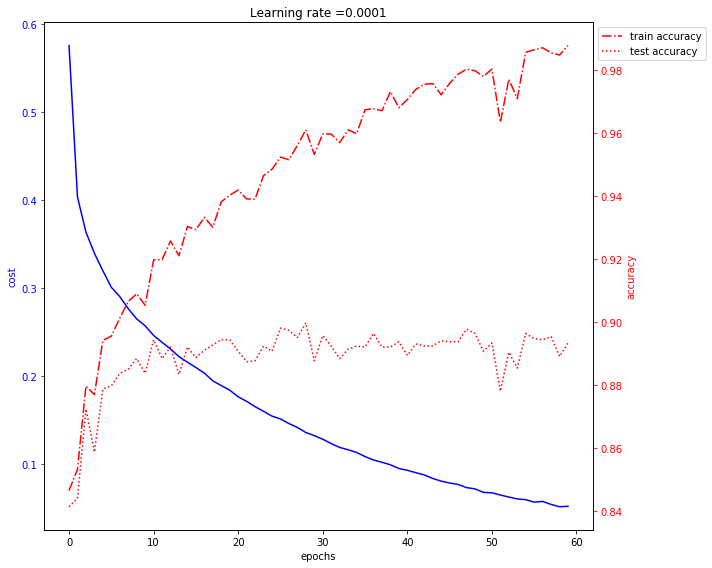

Parameters have been trained!
Execution time 889.370867
Final Train Accuracy: 0.9877018
Final Test Accuracy: 0.8933333


In [20]:
parameters, costs, train_accuracy, test_accuracy = model(train_set_X, train_set_Y_one_hot, 
                                                         dev_set_X, dev_set_Y_one_hot, 
                                                         learning_rate = 0.0001, beta = 0.0, 
                                                         num_epochs = 60)
                    # optimizer - Adam
                    # default layer sizes - layer_sizes = [784, 400, 150, 10]

In [104]:
                # just a reminder that we can now plot outside the model training function
# plot_training_by_epoch (costs, train_accuracy, test_accuracy, learning_rate = 0.0001)

Training for 20 epochs (about 5.5 minutes on my intel Core i5-3380M laptop with no GPU), the model gets to about 94% training accuracy and 89.7% test accuracy with a training cost of 0.17, with the cost function still decreasing suggesting training still has a fair way to go. To speed up training I think an adaptive learning rate may be beneficial.

Trained for 60 epochs (about 15 minutes) made a substantial improvement in the training cost (0.06) resulting in a training accuracy of 98.8%. Interestingly, the model has a substantial variance problem, with the test accuracy reaching about 89% after about 10 epochs, and then essentially remaining static while the model over-fits to the training data.

In [21]:
def predict(X, parameters):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (softmax: probability/confidence of each class)
    """

    # Retrieve the parameters from the dictionary "parameters"     
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    x = tf.placeholder("float", [784, None])  
            # IMPORTANT Note we need to use None here as we 
            # don't know how many training
            # examples will be passed in via feed_dict

                                                           
    Z1 = tf.add(tf.matmul(W1, X), b1)                      
    A1 = tf.nn.relu(Z1)                                    
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     
    A2 = tf.nn.relu(Z2)                                    
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     
    
    # Computes probabilities using forward propagation, 
    # and classifies to 0/1 using 0.5 as the threshold.
  
    p = tf.argmax(Z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

In [22]:
def evaluate_predictions_byclass (X, Y, num_classes = 10):

    predict_set_X = X.astype(np.float32)
    # print ("predict_set_X:\n", predict_set_X)
    # predict_set_X = predict_set_X.reshape(2,1) 
    # predict_set_X.shape
    # type (predict_set_X[0,0]) # confirm type is float32

    prediction = predict (predict_set_X, parameters)
    print ("The model predicted:", prediction[0:9])
    print ("The correct labels are:\n", Y[0:9])
    
    evaluate_predictions = np.append(prediction.reshape(Y.shape), Y, axis=0)

    # get a vector of True/False values
    correct = (evaluate_predictions[0,:] == evaluate_predictions[1,:]) 
    print (correct[4000:4020])

    classes = np.arange(0, num_classes)

    # weight the bincount by True/False (ie only count correct responses)
    correct_by_class = np.bincount(evaluate_predictions[0,:], weights=correct) 
    totals_by_class = np.bincount(evaluate_predictions[1,:])

    accuracy_by_class = np.divide (correct_by_class, totals_by_class)
    return accuracy_by_class


In [23]:
evaluate_predictions_byclass (dev_set_X, dev_set_Y)

The model predicted: [7 7 0 0 8 4 9 7 5]
The correct labels are:
 [[7 7 6 ... 7 4 9]]
[]


array([0.85333333, 0.97333333, 0.80666667, 0.87333333, 0.85      ,
       0.97      , 0.71666667, 0.96666667, 0.95666667, 0.96666667])

The model suffers from accuracy on particularly on classes 0, 2, 4 and 6. 

# Error analysis

Let's see if we can get some insight into the types of errors the model is making and why, by visually inspecting some of the misclassified test items. First, we need to do a bit of data crunching on the vector of predictions (Y hat) and compare it to the correct answers (Y).

In [24]:
predict_set_X = dev_set_X.astype(np.float32) # fix the data type

prediction = predict (predict_set_X, parameters) # get the vector of predictions (i.e. Y hat)
print ("The model predicted:", prediction[0:9])
print ("The correct labels are:", dev_set_Y[0,0:9])
    
# bind the prediction vector (Y hat) with the correct label vector (Y)
evaluate_predictions = np.append(prediction.reshape(dev_set_Y.shape), dev_set_Y, axis=0)

# turn that into a vector of True/False values
correct = (evaluate_predictions[0,:] == evaluate_predictions[1,:]) 
classes = np.arange(0, 10) # how many discrete classes do we have

# weight the bincount by True/False (ie only count correct responses)
correct_by_class = np.bincount(evaluate_predictions[0,:], weights=correct) 
totals_by_class = np.bincount(evaluate_predictions[1,:])

accuracy_by_class = np.divide (correct_by_class, totals_by_class) # as a percentage
print (accuracy_by_class)

The model predicted: [7 7 0 0 8 4 9 7 5]
The correct labels are: [7 7 6 0 8 4 9 7 5]
[0.85333333 0.97333333 0.80666667 0.87333333 0.85       0.97
 0.71666667 0.96666667 0.95666667 0.96666667]


Now let's look just at the errors on the dev set.

dev_set_Y.shape: (1, 3000)
errors_Y.shape:  (320, 1)
errors_Y_hat.shape:  (320, 1)
errors_X.shape:  (784, 320)
errors_X_2d.shape:  (320, 28, 28)


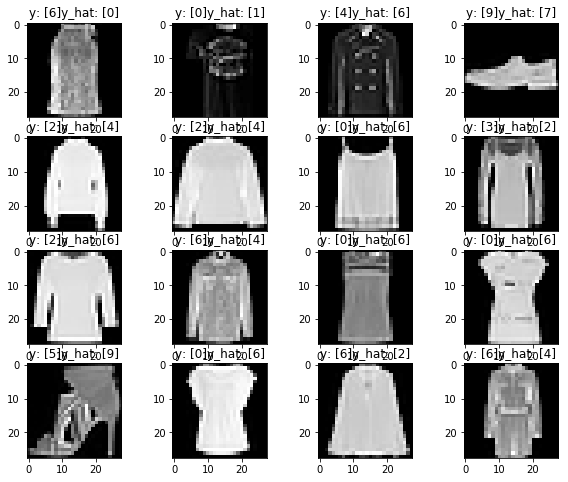

In [25]:
print ("dev_set_Y.shape:", dev_set_Y.shape)


errors_Y = dev_set_Y[:,correct==False].T    # use the correct vector as a mask to make a vector of 
                                            #just the labels (Y) for incorrect predictions
print ("errors_Y.shape: ", errors_Y.shape)  # how many errors do we have?

# use the correct mask to get a vector of incorrect predictions (Y hat)
errors_Y_hat = prediction[correct==False].T 
errors_Y_hat = errors_Y_hat.reshape(errors_Y_hat.shape[0],1)
print ("errors_Y_hat.shape: ", errors_Y_hat.shape)

# use the mask to get the images for the errors  
errors_X = dev_set_X[:,correct==False]      
print ("errors_X.shape: ", errors_X.shape)

# transpose and make back into a 28x28 image
errors_X_2d = errors_X.T.reshape(errors_X.shape[1], 28, 28) 
print ("errors_X_2d.shape: ", errors_X_2d.shape)

rows = 4
cols = 4
fig, axarr = plt.subplots(rows, cols)

for r in range (0, rows):
    for c in range (0, cols):
        axarr[r][c].title.set_text("y: " + str(errors_Y[(r*cols)+c]) + "y_hat: " + str(errors_Y_hat[(r*cols)+c]) )
        axarr[r][c].imshow(errors_X_2d[(r*cols)+c])

## some ad-hoc hyperparameter tuning

Let's see if we can make any inroads into the variance problem. First of all, let's try the Adagra

by firing up some regularization. Let's train for 30 epochs to start with. 

Cost after epoch 0: 0.909999, running for 12.711614 seconds
Cost after epoch 5: 0.533495, running for 89.533249 seconds
Cost after epoch 10: 0.445696, running for 168.391363 seconds
Cost after epoch 15: 0.396449, running for 242.128832 seconds
Cost after epoch 20: 0.364574, running for 311.605960 seconds
Cost after epoch 25: 0.344142, running for 382.946527 seconds


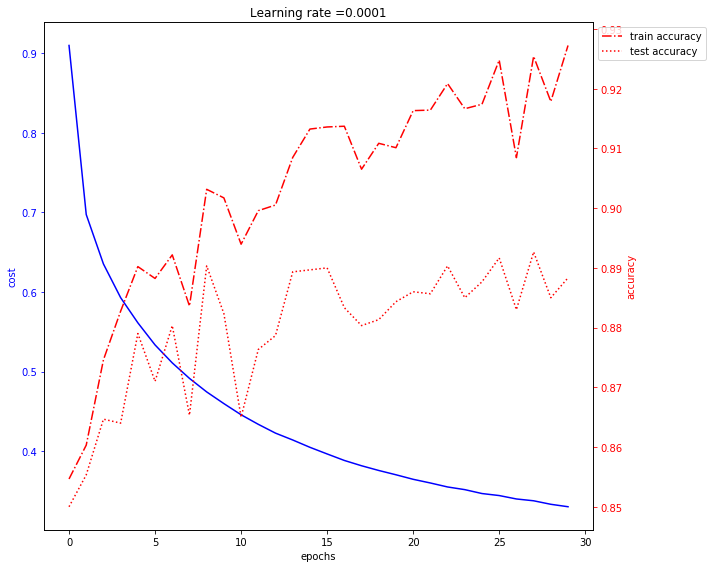

Parameters have been trained!
Execution time 439.061393
Final Train Accuracy: 0.9272456
Final Test Accuracy: 0.8883333


In [26]:
parameters = model(train_set_X, train_set_Y_one_hot, dev_set_X, dev_set_Y_one_hot, 
                   learning_rate = 0.01, beta = 0.0, num_epochs = 30)

                    # default layer sizes - layer_sizes = [784, 400, 150, 10]

Regularization mostly seems to make both the Train and Test accuracy worse!

Cost after epoch 0: 0.621030, running for 10.579314 seconds
Cost after epoch 5: 0.119387, running for 83.356093 seconds
Cost after epoch 10: 0.067033, running for 140.474591 seconds
Cost after epoch 15: 0.040221, running for 213.640597 seconds
Cost after epoch 20: 0.023949, running for 272.137401 seconds
Cost after epoch 25: 0.013723, running for 331.020758 seconds
Cost after epoch 30: 0.007415, running for 389.619084 seconds
Cost after epoch 35: 0.003591, running for 448.891508 seconds


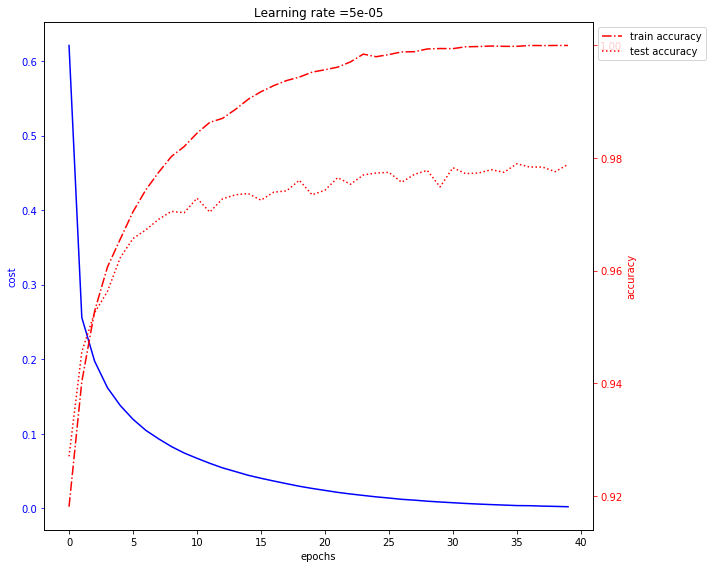

Parameters have been trained!
Execution time 499.989835
Final Train Accuracy: 0.99996114
Final Test Accuracy: 0.9788484


In [112]:
# try smaller learning rate trained for longer
parameters = model(train_set_X, train_set_Y_one_hot, dev_set_X, dev_set_Y_one_hot, 
                   learning_rate = 0.00005, beta = 0.0, num_epochs = 40)
                    # was: learning rate = 0.00005, beta = 0.0001
                    # default layer sizes - layer_sizes = [784, 400, 150, 10]

A lower learning rate slightly improves performance on the test set (97.9%), at the cost of a significantly longer training time (40 epochs = nearly 10 minutes on my CPU). One option would be to speed things up and automate some of the hyperparameter tuning by using a quick and dirty implementation of an adaptive learning rate, e.g. starting out with 0.0001 or 0.001 and making it smaller eg. by a factor of 10 every 10 epochs or so.